# Med-ai: Your Personal Medical Drug Assistant

## Project Overview

This project aims to revolutionize drug recommendation and analysis by providing an intelligent, interactive system that addresses the following functionalities:

1. **Symptom-Based Drug Recommendation**: Users can input symptoms, and the system will recommend the most suitable drugs.

2. **Drug Details and Analysis**: Provide a brief explanation of drug salts, including their uses, recommended dosage, allergies, and potential hazards.

3. **Salt Detection from Images**: Leverage OCR technology to identify salt names from drug packaging images and provide detailed information about their usage using a transformer model.
 
4. **Real-Time Salt Detection**: Extend the image-based detection to real-time camera input for on-the-go analysis.

## Aim
To create an accessible and efficient system that simplifies drug selection and understanding for users, leveraging advanced AI models and real-time processing capabilities.



### Required Installations

In [20]:
#!pip install ultralytics
#!pip install pytesseract

### Importing the necessary libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [50]:
import os
import yaml
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pytesseract
from transformers import AutoTokenizer, AutoModelForCausalLM
sns.set_theme(style="darkgrid", font="SimHei", rc={"axes.unicode_minus":False})

import torch
from ultralytics import YOLO

from PIL import Image

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Phase I ( Drug-Label Detection )

## Model Loading & Getting the data ready in YOLO Format

In [4]:
model = YOLO("yolov8n.pt")

100%|██████████| 6.25M/6.25M [00:00<00:00, 87.8MB/s]


In [5]:
config = {
    "path": "/kaggle/input/the-drug-name-detection-dataset",
    "train": "/kaggle/input/the-drug-name-detection-dataset/train",
    "val": "/kaggle/input/the-drug-name-detection-dataset/valid",
    "test": "/kaggle/input/the-drug-name-detection-dataset/test",
    "nc": 1,
    "names": ["drug-name"],
}

with open("data.yaml", "w") as file:
    yaml.dump(config, file, default_flow_style=False)

In [6]:
!wandb disabled

W&B disabled.


## Model Training

In [7]:
results = model.train(data="data.yaml", epochs=100, save_period=10, seed=seed, name="yolov8n")

Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=10, cache=False, device=None, workers=8, project=None, name=yolov8n, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=1, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wi

100%|██████████| 755k/755k [00:00<00:00, 18.0MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.4MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/the-drug-name-detection-dataset/train/labels... 1276 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1276/1276 [00:02<00:00, 447.14it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/the-drug-name-detection-dataset/train is not writeable, cache not saved.
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 182, len(boxes) = 1277. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/the-drug-name-detection-dataset/valid/labels... 365 images, 2 backgrounds, 0 corrupt: 100%|██████████| 365/365 [00:00<00:00, 439.83it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/the-drug-name-detection-dataset/valid is not writeable, cache not saved.
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 44, len(boxes) = 364. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/yolov8n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8n
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       2.2G      1.839      3.669      1.581         18        640: 100%|██████████| 80/80 [00:14<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.45it/s]


                   all        365        364      0.206      0.247      0.109     0.0482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.14G      1.751      2.972       1.58         19        640: 100%|██████████| 80/80 [00:12<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.31it/s]

                   all        365        364      0.146      0.187     0.0873     0.0342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.22G      1.781      2.621      1.618         18        640: 100%|██████████| 80/80 [00:12<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]

                   all        365        364      0.269      0.209       0.14     0.0587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.14G      1.771      2.403      1.622         16        640: 100%|██████████| 80/80 [00:12<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]

                   all        365        364      0.215      0.305       0.15     0.0576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.14G      1.736      2.293       1.62         18        640: 100%|██████████| 80/80 [00:13<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.35it/s]

                   all        365        364      0.226      0.354       0.19     0.0858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.14G      1.692      2.161      1.559         11        640: 100%|██████████| 80/80 [00:13<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.59it/s]

                   all        365        364      0.309      0.382       0.24       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.14G      1.669       2.08      1.543         20        640: 100%|██████████| 80/80 [00:13<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.40it/s]

                   all        365        364      0.228      0.324      0.207     0.0911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.14G      1.639      2.076      1.525         19        640: 100%|██████████| 80/80 [00:12<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.45it/s]

                   all        365        364      0.343      0.387      0.319      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.14G      1.591      1.991       1.49         18        640: 100%|██████████| 80/80 [00:13<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]

                   all        365        364      0.307      0.398       0.27      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.14G      1.601          2       1.49         19        640: 100%|██████████| 80/80 [00:12<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.34it/s]

                   all        365        364      0.364      0.347      0.279      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.14G      1.549      1.963       1.47         21        640: 100%|██████████| 80/80 [00:13<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.32it/s]

                   all        365        364      0.336      0.437      0.351      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.14G      1.574      1.947      1.474         14        640: 100%|██████████| 80/80 [00:13<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.24it/s]

                   all        365        364      0.371      0.376      0.327      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.14G      1.559      1.928      1.467         22        640: 100%|██████████| 80/80 [00:13<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]

                   all        365        364      0.346      0.511      0.337      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.14G       1.52      1.863       1.43         24        640: 100%|██████████| 80/80 [00:13<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.32it/s]

                   all        365        364       0.29      0.478      0.288      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.14G      1.507      1.823      1.439         20        640: 100%|██████████| 80/80 [00:13<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.29it/s]

                   all        365        364      0.353      0.489      0.336      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.13G      1.477      1.773      1.413         19        640: 100%|██████████| 80/80 [00:13<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.29it/s]

                   all        365        364       0.42      0.525       0.43      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.14G      1.529      1.801      1.444         19        640: 100%|██████████| 80/80 [00:13<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.50it/s]

                   all        365        364      0.442      0.525      0.423      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.13G      1.453      1.733      1.364         23        640: 100%|██████████| 80/80 [00:12<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.45it/s]

                   all        365        364      0.397      0.489      0.402      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.14G      1.468      1.755      1.396         17        640: 100%|██████████| 80/80 [00:13<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.58it/s]

                   all        365        364      0.439      0.445       0.39      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.14G      1.468       1.73      1.386         21        640: 100%|██████████| 80/80 [00:12<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.39it/s]

                   all        365        364      0.405      0.431      0.391      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.13G      1.445      1.728      1.388         27        640: 100%|██████████| 80/80 [00:13<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.28it/s]

                   all        365        364      0.378      0.536      0.386      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.13G      1.417      1.672      1.358         17        640: 100%|██████████| 80/80 [00:12<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]

                   all        365        364      0.437      0.525      0.422      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.13G       1.39      1.723      1.354         18        640: 100%|██████████| 80/80 [00:12<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.47it/s]

                   all        365        364      0.453      0.497      0.411      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.13G      1.392      1.621      1.339         21        640: 100%|██████████| 80/80 [00:12<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.59it/s]

                   all        365        364      0.464      0.522      0.475      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.13G       1.39      1.645      1.337         19        640: 100%|██████████| 80/80 [00:12<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.31it/s]

                   all        365        364      0.474      0.552      0.497      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.14G      1.404      1.603      1.333         13        640: 100%|██████████| 80/80 [00:13<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.49it/s]

                   all        365        364      0.522      0.541      0.485      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.13G      1.385      1.633       1.33         18        640: 100%|██████████| 80/80 [00:13<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]

                   all        365        364       0.58      0.459      0.501      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.13G       1.36      1.597      1.316         22        640: 100%|██████████| 80/80 [00:12<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.63it/s]

                   all        365        364      0.484      0.505      0.507      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.13G      1.383      1.613      1.322         27        640: 100%|██████████| 80/80 [00:12<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]

                   all        365        364      0.525      0.525      0.491      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.13G      1.344      1.565      1.305         21        640: 100%|██████████| 80/80 [00:13<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]

                   all        365        364      0.479      0.544      0.489      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.13G      1.342      1.547      1.298         22        640: 100%|██████████| 80/80 [00:13<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]

                   all        365        364      0.517      0.514      0.489      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.13G      1.332      1.593      1.302         18        640: 100%|██████████| 80/80 [00:12<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.51it/s]

                   all        365        364      0.468      0.549      0.477      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.13G      1.354      1.537      1.309         20        640: 100%|██████████| 80/80 [00:12<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]

                   all        365        364      0.565      0.547      0.559      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.13G      1.316      1.542      1.293         24        640: 100%|██████████| 80/80 [00:13<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.37it/s]

                   all        365        364      0.537      0.519      0.501       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.13G      1.335      1.521      1.293         14        640: 100%|██████████| 80/80 [00:12<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.24it/s]

                   all        365        364      0.509      0.558      0.542      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.13G       1.31      1.506      1.272         29        640: 100%|██████████| 80/80 [00:12<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.61it/s]

                   all        365        364      0.528      0.585      0.529      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.13G      1.311      1.505      1.276         16        640: 100%|██████████| 80/80 [00:12<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]

                   all        365        364      0.553      0.579      0.542      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.13G      1.321      1.482      1.275         24        640: 100%|██████████| 80/80 [00:12<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.51it/s]

                   all        365        364      0.528      0.599      0.559      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.13G      1.335      1.471      1.279         19        640: 100%|██████████| 80/80 [00:12<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]

                   all        365        364       0.56      0.584      0.578      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.13G      1.273      1.404       1.25         24        640: 100%|██████████| 80/80 [00:12<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.48it/s]

                   all        365        364      0.531      0.599      0.577      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.13G      1.275      1.415       1.27         21        640: 100%|██████████| 80/80 [00:12<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]

                   all        365        364       0.57      0.588      0.563      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.13G      1.277      1.403      1.252         19        640: 100%|██████████| 80/80 [00:12<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.33it/s]

                   all        365        364      0.608      0.546      0.589      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.13G      1.245      1.376      1.231         22        640: 100%|██████████| 80/80 [00:13<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.86it/s]

                   all        365        364      0.526      0.632      0.593      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.14G      1.243      1.392      1.236         12        640: 100%|██████████| 80/80 [00:12<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.59it/s]

                   all        365        364      0.603      0.588      0.612      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.13G      1.258      1.399      1.235         29        640: 100%|██████████| 80/80 [00:12<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.27it/s]

                   all        365        364       0.53      0.597      0.556      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.13G      1.237      1.392      1.226         22        640: 100%|██████████| 80/80 [00:12<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.35it/s]

                   all        365        364       0.56      0.618      0.588       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.13G      1.261       1.36      1.242         19        640: 100%|██████████| 80/80 [00:12<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]

                   all        365        364      0.508      0.596      0.545      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.13G      1.252      1.338       1.22         17        640: 100%|██████████| 80/80 [00:12<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.54it/s]

                   all        365        364       0.56      0.613      0.583      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.13G      1.235      1.301      1.209         18        640: 100%|██████████| 80/80 [00:12<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]

                   all        365        364        0.5      0.632      0.576       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.13G      1.209      1.297      1.207         22        640: 100%|██████████| 80/80 [00:12<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.49it/s]

                   all        365        364      0.617      0.588      0.607      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.13G      1.243      1.342      1.235         23        640: 100%|██████████| 80/80 [00:12<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]

                   all        365        364      0.647      0.585      0.637      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.13G      1.238      1.333       1.21         15        640: 100%|██████████| 80/80 [00:12<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.45it/s]

                   all        365        364      0.595      0.619      0.616      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.13G        1.2      1.294      1.192         17        640: 100%|██████████| 80/80 [00:12<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]

                   all        365        364      0.594       0.61       0.62      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.13G       1.21      1.297      1.221         24        640: 100%|██████████| 80/80 [00:12<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.54it/s]

                   all        365        364      0.589      0.636      0.616      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.13G       1.24      1.297      1.213         19        640: 100%|██████████| 80/80 [00:12<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]

                   all        365        364      0.596      0.596      0.593      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.13G      1.186      1.286       1.19         20        640: 100%|██████████| 80/80 [00:12<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.58it/s]

                   all        365        364      0.615      0.624      0.637       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.13G      1.182      1.263      1.181         23        640: 100%|██████████| 80/80 [00:12<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]

                   all        365        364      0.565      0.629      0.618      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.13G      1.189      1.278        1.2         21        640: 100%|██████████| 80/80 [00:12<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]

                   all        365        364      0.586      0.575      0.597      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.13G      1.186      1.279      1.197         23        640: 100%|██████████| 80/80 [00:12<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]

                   all        365        364       0.65      0.574      0.629      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.13G       1.14      1.235      1.166         20        640: 100%|██████████| 80/80 [00:12<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.63it/s]

                   all        365        364      0.641      0.574      0.632      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.13G      1.192      1.232      1.201         19        640: 100%|██████████| 80/80 [00:12<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]

                   all        365        364      0.624      0.637      0.673        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.13G       1.17       1.21      1.188         15        640: 100%|██████████| 80/80 [00:12<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.53it/s]

                   all        365        364      0.623      0.624      0.629      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.13G      1.142      1.202      1.163         19        640: 100%|██████████| 80/80 [00:12<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]

                   all        365        364      0.626      0.604      0.645      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.13G      1.187      1.216      1.181         17        640: 100%|██████████| 80/80 [00:12<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.42it/s]

                   all        365        364      0.626      0.602      0.631      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.13G      1.153      1.194      1.167         22        640: 100%|██████████| 80/80 [00:12<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.26it/s]

                   all        365        364      0.706      0.574      0.652      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.13G      1.169      1.181      1.177         20        640: 100%|██████████| 80/80 [00:13<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.63it/s]

                   all        365        364      0.599      0.661      0.643      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.13G      1.144      1.168      1.155         20        640: 100%|██████████| 80/80 [00:12<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]

                   all        365        364      0.603      0.662      0.643      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.13G      1.121      1.133      1.135         26        640: 100%|██████████| 80/80 [00:12<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]

                   all        365        364      0.671       0.64      0.666      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.13G      1.103      1.125      1.149         16        640: 100%|██████████| 80/80 [00:12<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]

                   all        365        364      0.661      0.643      0.682       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.13G      1.098      1.128      1.149         18        640: 100%|██████████| 80/80 [00:12<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.34it/s]

                   all        365        364      0.636      0.672      0.673      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.13G      1.107      1.134      1.138         23        640: 100%|██████████| 80/80 [00:12<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]

                   all        365        364      0.698      0.591       0.68      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.13G       1.11      1.102      1.131         29        640: 100%|██████████| 80/80 [00:12<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.51it/s]

                   all        365        364      0.673      0.637      0.682      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.13G      1.091      1.107      1.124         29        640: 100%|██████████| 80/80 [00:12<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.45it/s]

                   all        365        364      0.643      0.648      0.662      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.13G      1.113      1.097      1.146         19        640: 100%|██████████| 80/80 [00:12<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.48it/s]

                   all        365        364       0.63      0.673      0.666      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.13G      1.078       1.12      1.134         21        640: 100%|██████████| 80/80 [00:12<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]

                   all        365        364      0.661       0.64      0.664       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.13G      1.098       1.11      1.143         21        640: 100%|██████████| 80/80 [00:12<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.58it/s]

                   all        365        364      0.687      0.624      0.684      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.13G      1.118      1.092      1.155         21        640: 100%|██████████| 80/80 [00:12<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.49it/s]

                   all        365        364      0.694      0.593      0.651      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.13G      1.086      1.073       1.13         21        640: 100%|██████████| 80/80 [00:12<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.57it/s]

                   all        365        364      0.712      0.624      0.683      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.13G      1.108      1.052      1.126         21        640: 100%|██████████| 80/80 [00:12<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.50it/s]

                   all        365        364      0.678      0.637      0.666      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.13G      1.083      1.031      1.118         23        640: 100%|██████████| 80/80 [00:12<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.73it/s]

                   all        365        364      0.674      0.684      0.684      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.13G      1.074      1.051      1.119         28        640: 100%|██████████| 80/80 [00:12<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.38it/s]

                   all        365        364      0.672      0.636      0.666      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.13G      1.083      1.026       1.12         20        640: 100%|██████████| 80/80 [00:12<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.69it/s]

                   all        365        364      0.673      0.627      0.669      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.13G      1.071      1.025      1.107         19        640: 100%|██████████| 80/80 [00:12<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.65it/s]

                   all        365        364      0.675      0.665      0.672      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.13G      1.056      1.027       1.11         21        640: 100%|██████████| 80/80 [00:12<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.70it/s]

                   all        365        364      0.661       0.66       0.68       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.13G      1.048     0.9771        1.1         25        640: 100%|██████████| 80/80 [00:12<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.72it/s]

                   all        365        364      0.633      0.663      0.669      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.13G      1.049     0.9799        1.1         16        640: 100%|██████████| 80/80 [00:12<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.76it/s]

                   all        365        364      0.668      0.679      0.685      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.13G      1.036      0.992      1.105         19        640: 100%|██████████| 80/80 [00:12<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.61it/s]

                   all        365        364      0.662      0.687        0.7      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.13G      1.018     0.9952      1.096         20        640: 100%|██████████| 80/80 [00:12<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.76it/s]

                   all        365        364      0.653      0.678      0.676      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.13G      1.031      0.992      1.092         24        640: 100%|██████████| 80/80 [00:12<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.77it/s]

                   all        365        364      0.658      0.689      0.689      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.13G      1.044     0.9692      1.109         21        640: 100%|██████████| 80/80 [00:12<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.85it/s]

                   all        365        364      0.677      0.698      0.691       0.44


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.13G     0.9532     0.8634      1.052         12        640: 100%|██████████| 80/80 [00:13<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.83it/s]

                   all        365        364      0.667       0.67      0.679      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.14G      0.937     0.8226      1.045         13        640: 100%|██████████| 80/80 [00:12<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.71it/s]

                   all        365        364      0.702      0.635      0.703      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.13G     0.9398     0.8008      1.048         12        640: 100%|██████████| 80/80 [00:12<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.67it/s]

                   all        365        364       0.66      0.671      0.693      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.13G     0.9208     0.7828      1.042         12        640: 100%|██████████| 80/80 [00:12<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.60it/s]

                   all        365        364      0.704       0.67      0.698      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.13G     0.9181     0.7754      1.041         12        640: 100%|██████████| 80/80 [00:12<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.74it/s]

                   all        365        364      0.701       0.67      0.691      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.13G     0.9108      0.774      1.043         12        640: 100%|██████████| 80/80 [00:12<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.78it/s]

                   all        365        364      0.717      0.651      0.704      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.13G     0.9075     0.7515      1.033         12        640: 100%|██████████| 80/80 [00:12<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.80it/s]

                   all        365        364      0.725      0.665       0.71      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.13G     0.8875     0.7429      1.023         11        640: 100%|██████████| 80/80 [00:12<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.50it/s]

                   all        365        364       0.74      0.648      0.711      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.13G     0.8889     0.7401      1.034         12        640: 100%|██████████| 80/80 [00:12<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.40it/s]

                   all        365        364      0.725      0.658      0.706      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.14G      0.882     0.7326      1.026         13        640: 100%|██████████| 80/80 [00:12<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.59it/s]

                   all        365        364       0.73      0.654      0.714       0.46



100 epochs completed in 0.441 hours.
Optimizer stripped from runs/detect/yolov8n/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/yolov8n/weights/best.pt, 6.3MB

Validating runs/detect/yolov8n/weights/best.pt...
Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.64it/s]


                   all        365        364      0.728      0.654      0.714       0.46
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/yolov8n


## Evaluation

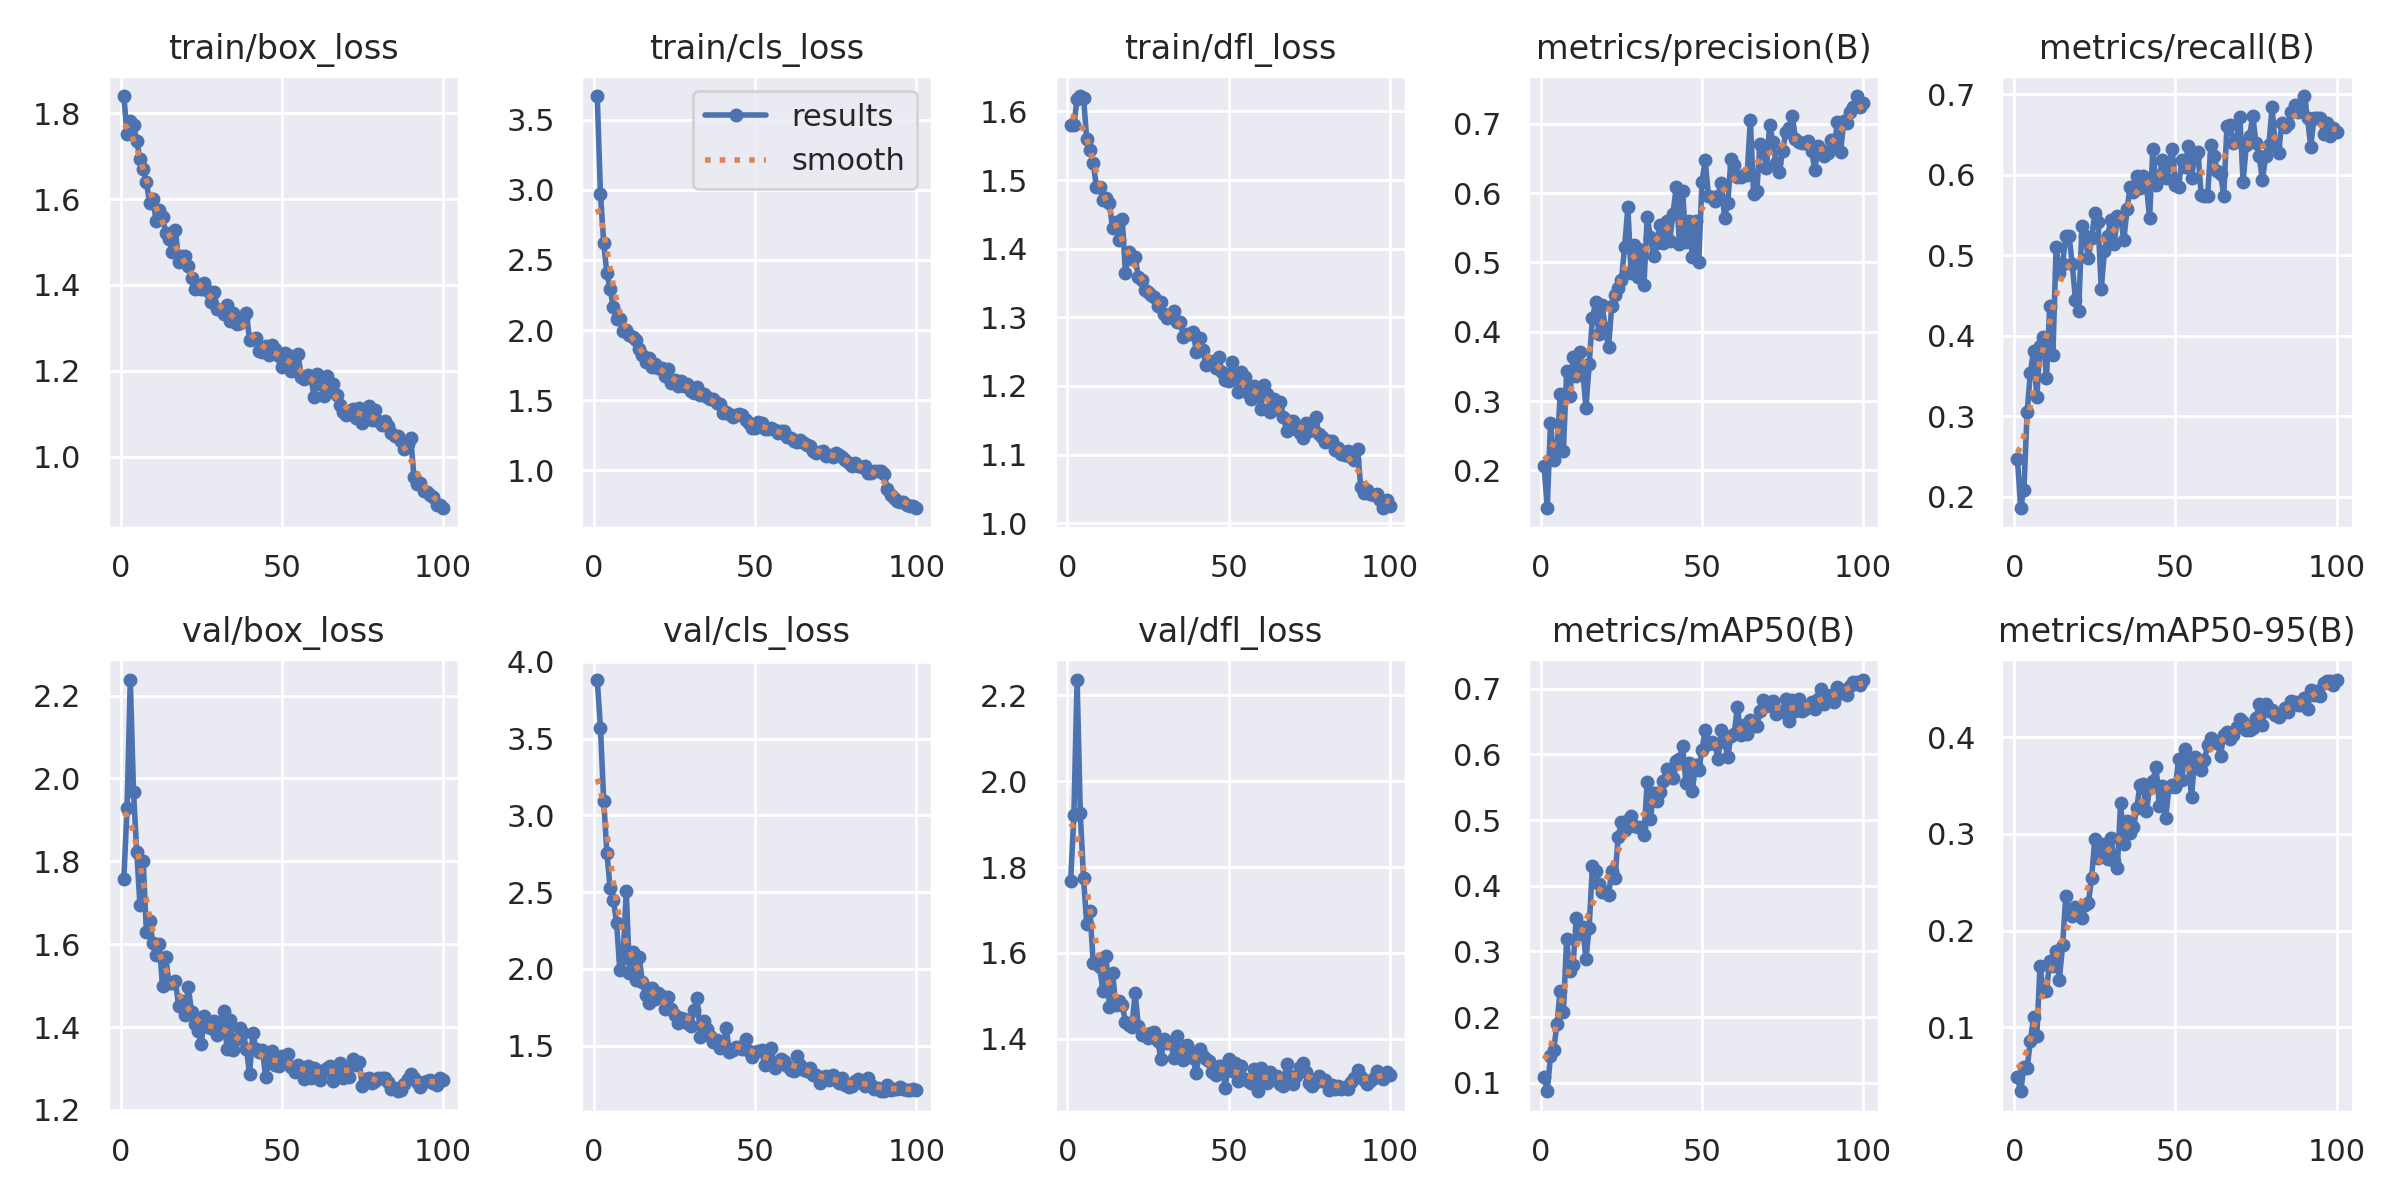

In [8]:
Image.open("/kaggle/working/runs/detect/yolov8n/results.png")

## Model Testing

In [9]:
paths = glob.glob("/kaggle/input/the-drug-name-detection-dataset/test/images/*")


0: 640x640 1 drug-name, 8.6ms
1: 640x640 2 drug-names, 8.6ms
2: 640x640 1 drug-name, 8.6ms
3: 640x640 1 drug-name, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


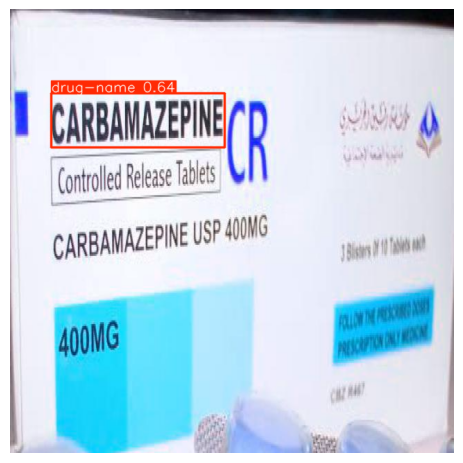

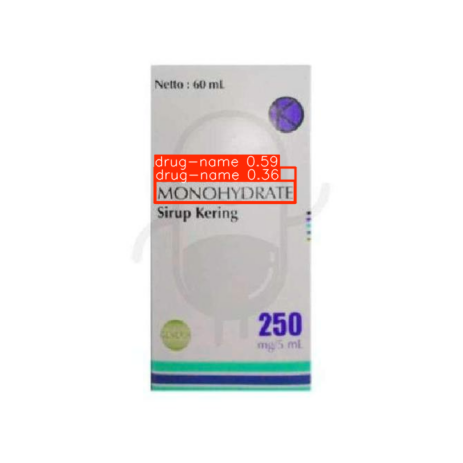

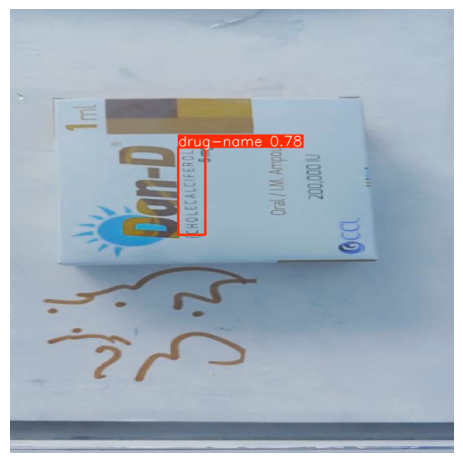

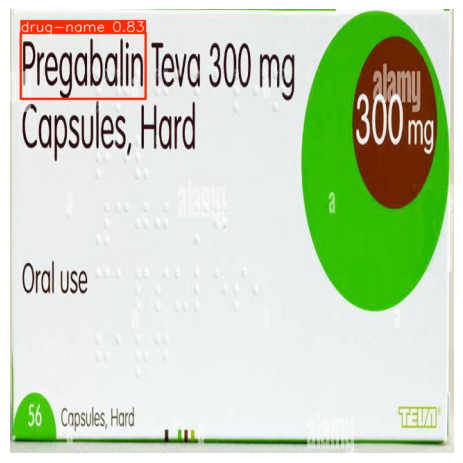

In [11]:
n = 4
results = model.predict(paths[:n])
for i in range(n):
    r = results[i]
    img = Image.fromarray(r.plot())
    plt.figure(dpi=100)
    plt.imshow(img)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

**Our Model is working fine on detecting the labels from the drugs**

# Pahse II ( Integration Of OCR )

## Function Defn.

In [23]:
def apply_ocr_on_predictions(image_path, results):
    image = cv2.imread(image_path) 
    ocr_results = []     
    for result in results: 
        for box in result.boxes: 
            x_min, y_min, x_max, y_max = map(int, box.xyxy[0].cpu().numpy()) 
            
            # Crop the region of interest (ROI) from the image
            cropped_img = image[y_min:y_max, x_min:x_max]
            
            # Convert to PIL image for OCR processing
            pil_image = Image.fromarray(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
            
            # Perform OCR using pytesseract
            extracted_text = pytesseract.image_to_string(pil_image, lang='eng').strip()
            ocr_results.append((x_min, y_min, x_max, y_max, extracted_text))
            
            # Display the cropped image and OCR result
            plt.figure(figsize=(4, 4))
            plt.imshow(pil_image)
            plt.title(f"Extracted Text: {extracted_text}")
            plt.axis("off")
            plt.show()
    
    return ocr_results

## Example-Run


image 1/1 /kaggle/input/the-drug-name-detection-dataset/test/images/Indapamide_jpeg.rf.95efee6e65ef004f68750faaf8bef7bb.jpg: 640x640 1 drug-name, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


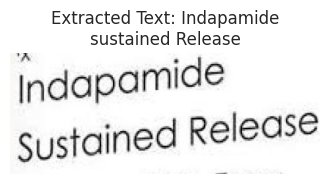

OCR Results:
Bounding Box: (60, 101, 533, 286), Extracted Text: Indapamide
sustained Release


In [35]:
image_path = paths[7] 
results = model.predict(image_path)  # Run predictions on the image

ocr_results = apply_ocr_on_predictions(image_path, results)

print("OCR Results:")
for (x_min, y_min, x_max, y_max, text) in ocr_results:
    print(f"Bounding Box: ({x_min}, {y_min}, {x_max}, {y_max}), Extracted Text: {text}")

**This Function is working Fine**

# Next , VS-Code

## ☺️